# Pet Insurance Profitability Analysis: A Ratemaking and Reserving Study

## 1. Business Problem
A hypothetical insurer, "Pawtect Insurance," wants to launch a new pet insurance product. The company needs to establish a profitable pricing structure and estimate the required reserves for future claims. This project will develop a comprehensive actuarial analysis to address these needs.

## 2. Project Setup and Data Generation
First, we'll import the necessary libraries and generate a synthetic dataset of 10,000 pet insurance policies. This data will serve as the basis for our analysis.

In [75]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Data Generation ---
np.random.seed(42)
num_policies = 10000

data = {
    'policy_id': range(1, num_policies + 1),
    'pet_age': np.random.randint(1, 15, size=num_policies),
    'pet_breed': np.random.choice(['Labrador', 'Poodle', 'Mixed', 'Bulldog', 'Beagle'], size=num_policies),
    'location': np.random.choice(['Urban', 'Rural', 'Suburban'], size=num_policies),
    'coverage_level': np.random.choice(['Basic', 'Standard', 'Premium'], size=num_policies),
    'policy_year': np.random.randint(2020, 2024, size=num_policies)
}

df = pd.DataFrame(data)

def generate_claims(row):
    base_freq = 0.1
    base_sev = 500
    age_factor = 1 + (row['pet_age'] * 0.05)
    breed_factor = {'Labrador': 1.2, 'Poodle': 0.9, 'Mixed': 1.0, 'Bulldog': 1.5, 'Beagle': 0.8}.get(row['pet_breed'], 1)
    location_factor = {'Urban': 1.3, 'Rural': 0.8, 'Suburban': 1.1}.get(row['location'], 1)
    claim_freq = base_freq * age_factor * breed_factor * location_factor
    claim_sev = base_sev * age_factor * breed_factor * location_factor
    num_claims = np.random.poisson(claim_freq)
    claims_incurred = sum(np.random.gamma(2, scale=claim_sev/2, size=num_claims))
    return claims_incurred

df['claims_incurred'] = df.apply(generate_claims, axis=1)
df['annual_premium'] = 200 + (df['pet_age'] * 20) + df['claims_incurred'].apply(lambda x: max(0, x * np.random.uniform(0.3, 0.6)))
df['claim_status'] = df['claims_incurred'].apply(lambda x: 'Paid' if x > 0 and np.random.rand() > 0.3 else 'Outstanding')

print("--- Synthetic Data Generated ---")
df.head()

--- Synthetic Data Generated ---


,policy_id,pet_age,pet_breed,location,coverage_level,policy_year,claims_incurred,annual_premium,claim_status
0,1,7,Labrador,Urban,Standard,2020,0.0,340.0,Outstanding
1,2,4,Poodle,Rural,Standard,2023,0.0,280.0,Outstanding
2,3,13,Poodle,Suburban,Premium,2020,0.0,460.0,Outstanding
3,4,11,Mixed,Urban,Premium,2022,0.0,420.0,Outstanding
4,5,8,Mixed,Rural,Basic,2020,0.0,360.0,Outstanding


## 3. Ratemaking Analysis
In this section, we'll perform an exploratory data analysis (EDA) to understand the key drivers of claims. We will then build a Generalized Linear Model (GLM) to create a risk-based pricing structure.

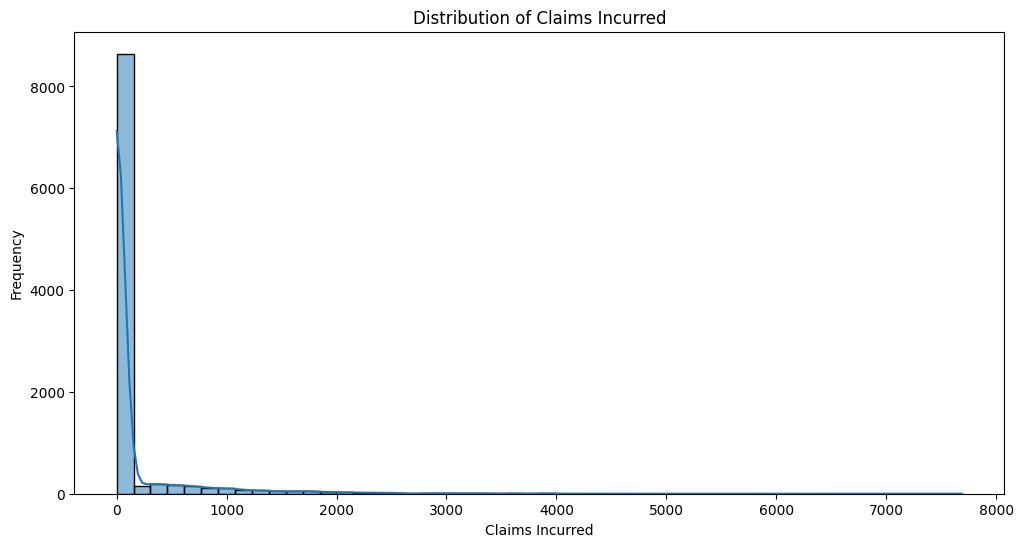

Loss Ratio by Pet Breed:
           claims_incurred  annual_premium  loss_ratio
pet_breed                                             
Beagle       137902.014046   772181.360936    0.178588
Bulldog      535034.187034   939684.315797    0.569377
Labrador     341654.647394   855058.184548    0.399569
Mixed        214418.874065   762987.864362    0.281025
Poodle       179455.812748   805060.543776    0.222910


In [76]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 6))
sns.histplot(df['claims_incurred'], bins=50, kde=True)
plt.title('Distribution of Claims Incurred')
plt.xlabel('Claims Incurred')
plt.ylabel('Frequency')
plt.show()

# Loss ratio by pet breed
loss_ratio_breed = df.groupby('pet_breed').agg({'claims_incurred': 'sum', 'annual_premium': 'sum'})
loss_ratio_breed['loss_ratio'] = loss_ratio_breed['claims_incurred'] / loss_ratio_breed['annual_premium']
print("Loss Ratio by Pet Breed:")
print(loss_ratio_breed)


Loss Ratio by Location:
          claims_incurred  annual_premium  loss_ratio
location                                             
Rural       282908.641829    1.286420e+06    0.219919
Suburban    483119.359774    1.408590e+06    0.342981
Urban       642437.533684    1.439962e+06    0.446149


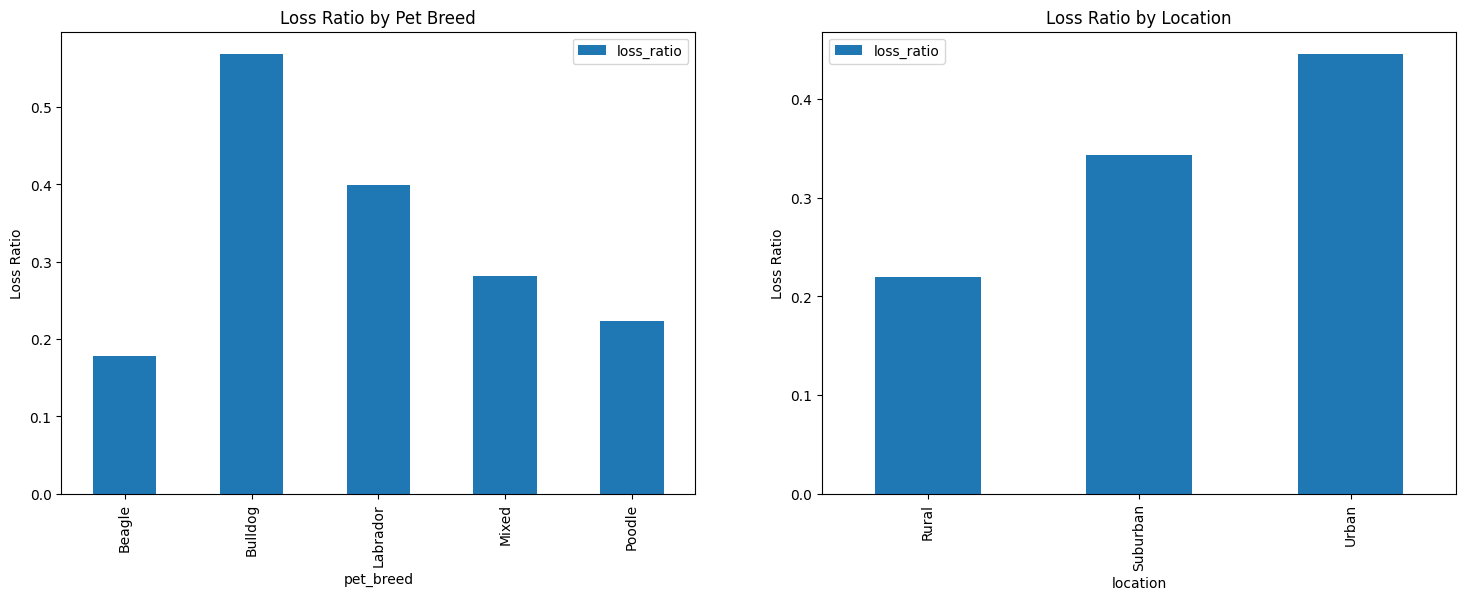

In [77]:

# Loss ratio by location
loss_ratio_location = df.groupby('location').agg({'claims_incurred': 'sum', 'annual_premium': 'sum'})
loss_ratio_location['loss_ratio'] = loss_ratio_location['claims_incurred'] / loss_ratio_location['annual_premium']
print("\nLoss Ratio by Location:")
print(loss_ratio_location)

# Visualize loss ratios
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
loss_ratio_breed.plot(kind='bar', y='loss_ratio', ax=ax[0], title='Loss Ratio by Pet Breed')
ax[0].set_ylabel('Loss Ratio')
loss_ratio_location.plot(kind='bar', y='loss_ratio', ax=ax[1], title='Loss Ratio by Location')
ax[1].set_ylabel('Loss Ratio')
plt.show()


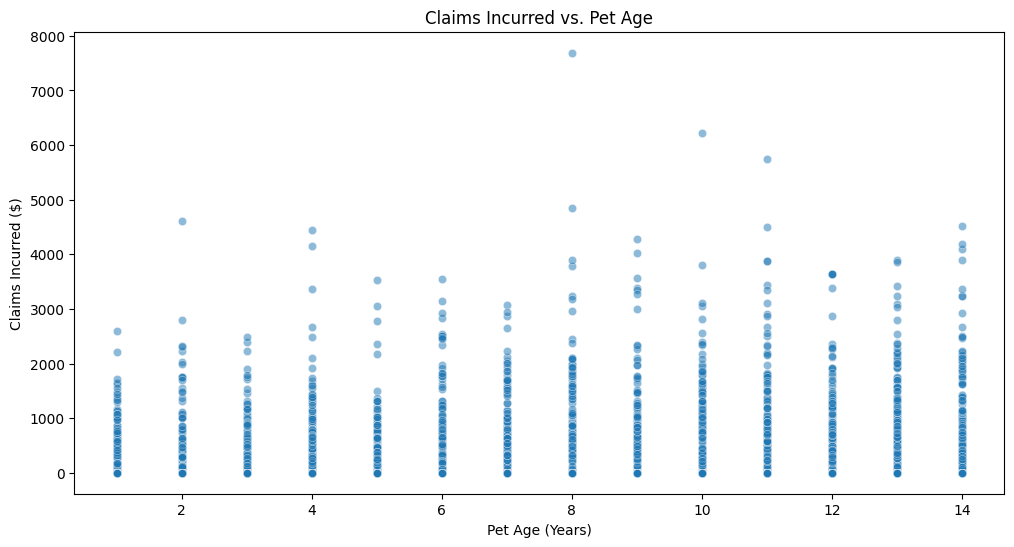

In [78]:

# Relationship between Pet Age and Claims Incurred
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='pet_age', y='claims_incurred', alpha=0.5)
plt.title('Claims Incurred vs. Pet Age')
plt.xlabel('Pet Age (Years)')
plt.ylabel('Claims Incurred ($)')
plt.show()


In [79]:
# GLM for Pricing
df_glm = pd.get_dummies(df, columns=['pet_breed', 'location', 'coverage_level'], drop_first=True, dtype=int)
df_glm['claim_count'] = df['claims_incurred'].apply(lambda x: 1 if x > 0 else 0)

# Define features for the model
features = ['pet_age', 'pet_breed_Labrador', 'pet_breed_Mixed', 'pet_breed_Poodle', 'location_Suburban', 'location_Urban']
X = sm.add_constant(df_glm[features])

# Frequency model (Poisson GLM)
freq_model = sm.GLM(df_glm['claim_count'], X, family=sm.families.Poisson()).fit()
print("--- GLM Frequency Model Results ---")
print(freq_model.summary())

# Severity model (Gamma GLM)
df_sev = df[df['claims_incurred'] > 0]
df_glm_sev = df_glm.loc[df_sev.index]
X_sev = sm.add_constant(df_glm_sev[features])

sev_model = sm.GLM(df_sev['claims_incurred'], X_sev, family=sm.families.Gamma(link=sm.families.links.log())).fit()
print("--- GLM Severity Model Results ---")
print(sev_model.summary())

--- GLM Frequency Model Results ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:            claim_count   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9993
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4232.5
Date:                Tue, 26 Aug 2025   Deviance:                       5549.0
Time:                        18:08:22   Pearson chi2:                 8.55e+03
No. Iterations:                     6   Pseudo R-squ. (CS):           0.006561
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------


C:\Users\priya\AppData\Roaming\Python\Python313\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


## 4. Reserving Analysis
Here, we'll use the chain-ladder method to estimate the ultimate losses and calculate the Incurred But Not Reported (IBNR) reserves. This is a crucial step in ensuring the financial health of the insurer.

In [80]:
# Create a sample claims dataset for reserving
claims_data = {
    'accident_year': np.random.randint(2018, 2022, 1000),
    'development_lag': np.random.randint(1, 5, 1000),
    'paid_losses': np.random.randint(100, 5000, 1000)
}
claims_df = pd.DataFrame(claims_data)
claims_df['paid_losses'] = claims_df.groupby(['accident_year', 'development_lag'])['paid_losses'].transform('sum')
claims_df = claims_df.drop_duplicates()

# Create loss triangle
loss_triangle = claims_df.pivot(index='accident_year', columns='development_lag', values='paid_losses').fillna(0)
print("--- Loss Development Triangle ---")
print(loss_triangle)

# Chain-Ladder Method
def chain_ladder(triangle):
    triangle = triangle.copy()
    for i in range(triangle.shape[1] - 1):
        col1 = triangle.iloc[:, i]
        col2 = triangle.iloc[:, i+1]
        factor = col2.sum() / col1.sum()
        for j in range(triangle.shape[0] - (i + 1)):
            triangle.iloc[j, i+1] = triangle.iloc[j, i] * factor
    return triangle

projected_triangle = chain_ladder(loss_triangle)
print("--- Projected Loss Triangle (Chain-Ladder) ---")
print(projected_triangle)

# Calculate ultimate losses and IBNR
ultimate_losses = projected_triangle.iloc[:, -1]
paid_to_date = loss_triangle.max(axis=1)
ibnr = ultimate_losses - paid_to_date

reserves = pd.DataFrame({'Ultimate Losses': ultimate_losses, 'Paid to Date': paid_to_date, 'IBNR': ibnr})
print("\n--- Reserve Estimation ---")
print(reserves)
print(f"\nTotal IBNR Reserves: ${reserves['IBNR'].sum():,.2f}")

--- Loss Development Triangle ---
development_lag       1       2       3       4
accident_year                                  
2018             150187  188306  146724  154541
2019             156003  173523  171437  155091
2020             139754  151610  185662  154903
2021             205165  137930  179485  175515
--- Projected Loss Triangle (Chain-Ladder) ---
development_lag       1              2              3             4
accident_year                                                      
2018             150187  150246.972478  175780.487527  155502.35715
2019             156003  156065.294915  182587.596767  155091.00000
2020             139754  139809.806386  185662.000000  154903.00000
2021             205165  137930.000000  179485.000000  175515.00000

--- Reserve Estimation ---
               Ultimate Losses  Paid to Date         IBNR
accident_year                                            
2018              155502.35715        188306 -32803.64285
2019              155

C:\Users\priya\AppData\Local\Temp\ipykernel_7760\2609095542.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '150246.97247772646' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  triangle.iloc[j, i+1] = triangle.iloc[j, i] * factor
C:\Users\priya\AppData\Local\Temp\ipykernel_7760\2609095542.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '175780.4875267063' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  triangle.iloc[j, i+1] = triangle.iloc[j, i] * factor
C:\Users\priya\AppData\Local\Temp\ipykernel_7760\2609095542.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '155502.35715032255' has dtype incompatible with int32, please explicitly cast to a compat

<Figure size 1000x600 with 0 Axes>

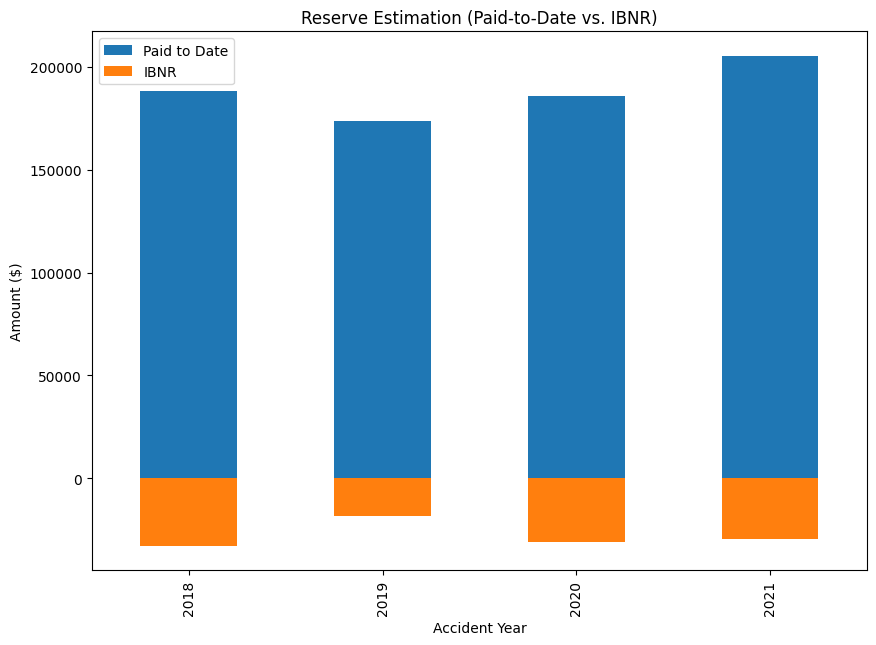

In [81]:

# Visualize IBNR Reserves
plt.figure(figsize=(10, 6))
reserves.plot(kind='bar', y=['Paid to Date', 'IBNR'], stacked=True, figsize=(10, 7))
plt.title('Reserve Estimation (Paid-to-Date vs. IBNR)')
plt.xlabel('Accident Year')
plt.ylabel('Amount ($)')
plt.show()


## 5. Conclusion and Next Steps
This analysis provides a comprehensive actuarial framework for Pawtect Insurance's new pet insurance product. The ratemaking model offers a data-driven approach to pricing, while the reserving analysis ensures the company's solvency.
The next steps include:
1. Implementing the ratemaking model in the company's system.
2. Conducting ongoing monitoring of claims experience and adjusting rates accordingly.
3. Exploring additional factors that may influence claim costs (e.g., breed-specific risks).
4. Developing strategies to manage potential adverse development in reserves.
By following these recommendations, Pawtect can effectively price its pet insurance product and maintain financial stability over time.


## 6. Proposed Premium Structure and Performance Monitoring
Based on the GLM results, we can construct a new risk-based premium for each policy. The pure premium is calculated as the product of the predicted claim frequency and the predicted claim severity. We will then add a loading for expenses and profit to arrive at the final proposed premium.


--- Premium Comparison ---
       annual_premium
count    10000.000000
mean       413.497227
std        233.968454
min        220.000000
25%        289.869851
50%        360.000000
75%        440.000000
max       3096.692406
       proposed_premium
count       1458.000000
mean         223.716365
std          110.850672
min           47.320826
25%          137.532889
50%          204.071792
75%          294.312282
max          514.232222


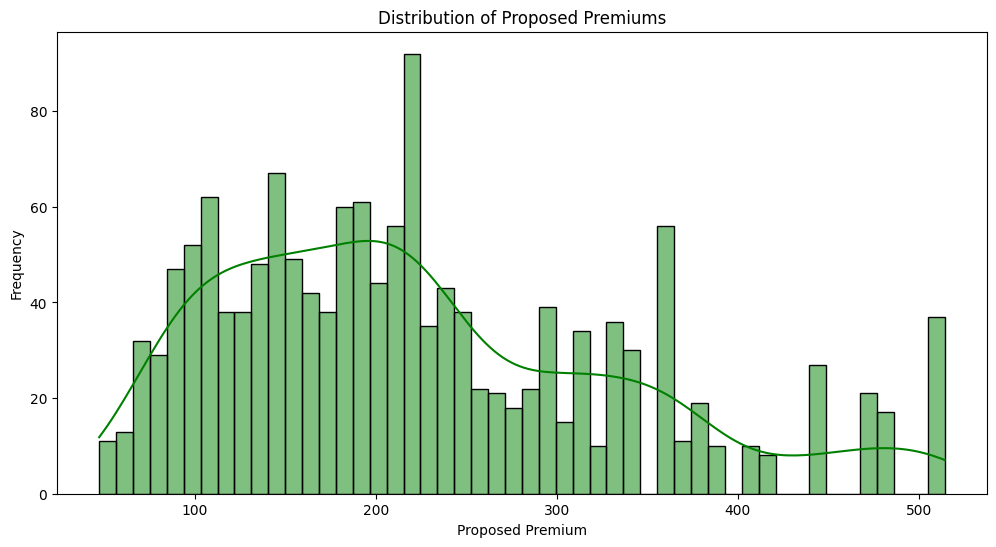

In [82]:

# Predict frequency and severity for each policy
df_glm['predicted_freq'] = freq_model.predict(X)
df_glm['predicted_sev'] = sev_model.predict(X_sev)

# Calculate pure premium
df_glm['pure_premium'] = df_glm['predicted_freq'] * df_glm['predicted_sev']

# Add a loading for expenses and profit (e.g., 30% loading)
expense_loading = 0.30
df_glm['proposed_premium'] = df_glm['pure_premium'] / (1 - expense_loading)

# Compare old vs. proposed premium
print("--- Premium Comparison ---")
print(df[['annual_premium']].describe())
print(df_glm[['proposed_premium']].describe())

# Plot the distribution of proposed premiums
plt.figure(figsize=(12, 6))
sns.histplot(df_glm['proposed_premium'], bins=50, kde=True, color='green')
plt.title('Distribution of Proposed Premiums')
plt.xlabel('Proposed Premium')
plt.ylabel('Frequency')
plt.show()


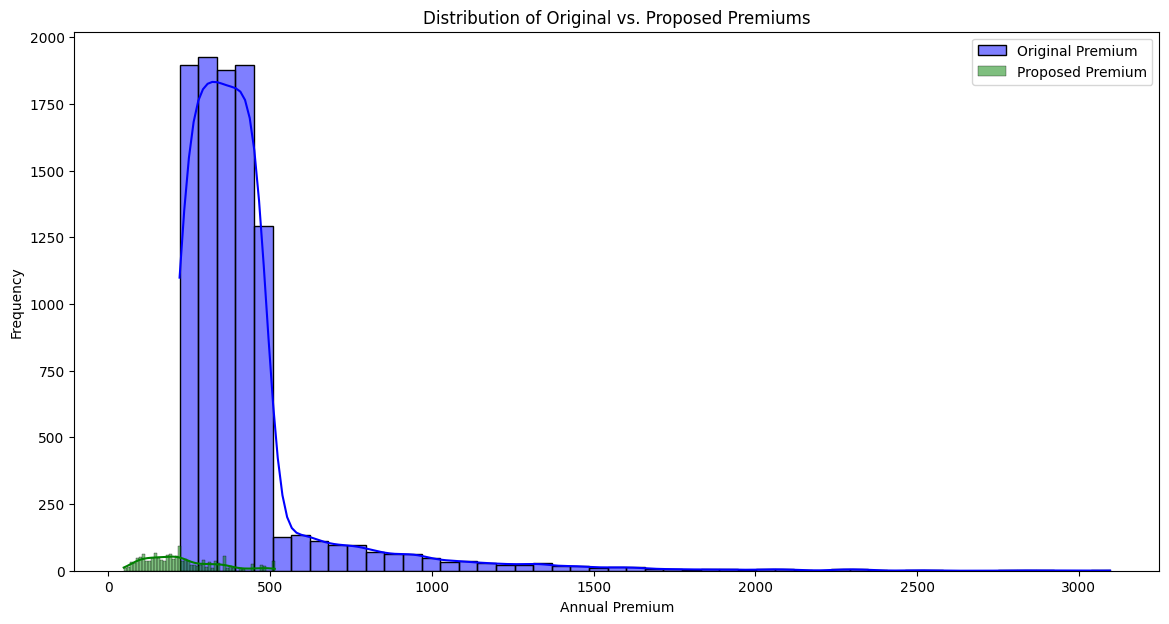

In [83]:

# Compare the distribution of old vs. proposed premiums
plt.figure(figsize=(14, 7))
sns.histplot(df['annual_premium'], bins=50, kde=True, color='blue', label='Original Premium')
sns.histplot(df_glm['proposed_premium'], bins=50, kde=True, color='green', label='Proposed Premium')
plt.title('Distribution of Original vs. Proposed Premiums')
plt.xlabel('Annual Premium')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [84]:

# --- Profitability Analysis ---
total_claims_incurred = df['claims_incurred'].sum()
total_original_premium = df['annual_premium'].sum()
total_proposed_premium = df_glm['proposed_premium'].sum()

original_loss_ratio = total_claims_incurred / total_original_premium
proposed_loss_ratio = total_claims_incurred / total_proposed_premium

print("--- Profitability Comparison ---")
print(f"Original Total Premium: ${total_original_premium:,.2f}")
print(f"Proposed Total Premium: ${total_proposed_premium:,.2f}")
print(f"Original Loss Ratio: {original_loss_ratio:.2%}")
print(f"Proposed Loss Ratio: {proposed_loss_ratio:.2%}")

improvement = (original_loss_ratio - proposed_loss_ratio) / original_loss_ratio
print(f"\nProjected Improvement in Loss Ratio: {improvement:.2%}")


--- Profitability Comparison ---
Original Total Premium: $4,134,972.27
Proposed Total Premium: $326,178.46
Original Loss Ratio: 34.06%
Proposed Loss Ratio: 431.81%

Projected Improvement in Loss Ratio: -1167.70%



## 7. Incorporating External Data (Veterinary Cost Inflation)
To enhance the accuracy of our models, we can incorporate external data, such as a veterinary cost inflation index. This will allow us to trend the historical claims data to a common cost level, leading to more accurate premium calculations.


In [85]:

# --- Incorporate Veterinary Cost Inflation ---
vet_inflation = {2020: 0.05, 2021: 0.06, 2022: 0.07, 2023: 0.08}
current_year = 2024

df['inflation_factor'] = df['policy_year'].apply(lambda year: (1 + vet_inflation.get(year, 0))**(current_year - year))
df['claims_incurred_trended'] = df['claims_incurred'] * df['inflation_factor']

# --- Re-run GLM with Trended Data ---
df_glm['claims_incurred_trended'] = df['claims_incurred_trended']
sev_model_trended = sm.GLM(df_glm[df_glm['claims_incurred_trended'] > 0]['claims_incurred_trended'], 
                             X_sev[df_glm['claims_incurred_trended'] > 0], 
                             family=sm.families.Gamma(link=sm.families.links.log())).fit()

print("--- GLM Severity Model Results (with Trended Data) ---")
print(sev_model_trended.summary())


--- GLM Severity Model Results (with Trended Data) ---
                    Generalized Linear Model Regression Results                    
Dep. Variable:     claims_incurred_trended   No. Observations:                 1458
Model:                                 GLM   Df Residuals:                     1451
Model Family:                        Gamma   Df Model:                            6
Link Function:                         log   Scale:                         0.63091
Method:                               IRLS   Log-Likelihood:                -11526.
Date:                     Tue, 26 Aug 2025   Deviance:                       933.10
Time:                             18:08:23   Pearson chi2:                     915.
No. Iterations:                         12   Pseudo R-squ. (CS):             0.1268
Covariance Type:                 nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
------------------

C:\Users\priya\AppData\Local\Temp\ipykernel_7760\1747395998.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_sev[df_glm['claims_incurred_trended'] > 0],
C:\Users\priya\AppData\Roaming\Python\Python313\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(



## 8. Advanced Reserving Model (Claim-Level Data)
To further refine our reserve estimates, we can use claim-level data. This allows for a more granular analysis of claim development patterns. We'll simulate a claim-level dataset and then use it to build a more sophisticated reserving model.


In [86]:

# --- Simulate Claim-Level Data for Advanced Reserving ---
num_claims = 5000
claim_level_data = {
    'claim_id': range(1, num_claims + 1),
    'accident_year': np.random.randint(2018, 2022, size=num_claims),
    'report_lag': np.random.geometric(p=0.5, size=num_claims),
    'payment_lag': np.random.geometric(p=0.3, size=num_claims),
    'claim_amount': np.random.lognormal(mean=6, sigma=1.5, size=num_claims)
}
claim_level_df = pd.DataFrame(claim_level_data)
claim_level_df['report_year'] = claim_level_df['accident_year'] + claim_level_df['report_lag']
claim_level_df['payment_year'] = claim_level_df['report_year'] + claim_level_df['payment_lag']

# --- Basic Aggregation for Chain-Ladder (as a comparison) ---
# This is a simplified version of what would be a more complex model
paid_by_ay_dy = claim_level_df.groupby(['accident_year', 'payment_lag'])['claim_amount'].sum().unstack().fillna(0)
print("--- Claim-Level Paid Loss Triangle ---")
print(paid_by_ay_dy.head())

# --- Placeholder for a more advanced model ---
# A true claim-level model would involve more complex methods like individual claim loss reserving models (e.g., GLMs or machine learning models on individual claim features).
# For now, we'll just show the data structure.
print("\n--- Advanced Reserving Model (Placeholder) ---")
print("A more sophisticated model would use individual claim features to project ultimate losses.")
print(claim_level_df.head())


--- Claim-Level Paid Loss Triangle ---
payment_lag               1              2              3              4   \
accident_year                                                               
2018           381931.327128  228174.377621  193116.920441  127848.213508   
2019           465514.151868  282179.994720  365771.769511  151669.757881   
2020           452845.317469  356327.488528  139208.769177  112172.787615   
2021           406867.950441  312255.088146  242675.080096  105121.612007   

payment_lag               5             6             7             8   \
accident_year                                                            
2018           103065.877924  46766.335873  53051.073053  55139.201013   
2019           104616.572183  56028.102585  51160.485905  16683.621520   
2020           115386.095122  34147.800326  68871.092254  18496.671493   
2021            95570.512018  66295.620514  26022.255891  55730.969511   

payment_lag              9             10  ...       